# Generic Nearest Neighborhood Analysis

In [3]:
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
import time
import sys
import matplotlib.pyplot as plt
import math
import os

from sklearn.cluster import MiniBatchKMeans
import seaborn as sns
import scanpy as sc

def get_windows(job,n_neighbors):
    start_time,idx,tissue_name,indices = job
    job_start = time.time()
    
    print ("Starting:", str(idx+1)+'/'+str(len(exps)),': ' + exps[idx])

    tissue = tissue_group.get_group(tissue_name)
    to_fit = tissue.loc[indices][[X,Y]].values

    fit = NearestNeighbors(n_neighbors=n_neighbors).fit(tissue[[X,Y]].values)
    m = fit.kneighbors(to_fit)

    #sort_neighbors
    args = m[0].argsort(axis = 1)
    add = np.arange(m[1].shape[0])*m[1].shape[1]
    sorted_indices = m[1].flatten()[args+add[:,None]]

    neighbors = tissue.index.values[sorted_indices]
   
    end_time = time.time()
   
    print ("Finishing:", str(idx+1)+"/"+str(len(exps)),": "+ exps[idx],end_time-job_start,end_time-start_time)
    return neighbors.astype(np.int32)


In [4]:
#Choose this information and input based on above
ks = [25,100] # k=5 means it collects 5 nearest neighbors for each center cell
path_to_data = "G:/HuBMAP/B008_12/Neighborhoods/05_25_HuBMAP_comm4.csv"

X = 'x'
Y = 'y'
reg = 'unique_region'
file_type = 'csv'

cluster_col = 'Cell Type'
cellhier_path = 'G:/cellhier'

separator = 'Segment4'
keep_cols = [X,Y,reg,cluster_col,separator]
save_path = 'G:/HuBMAP/B008_12/Neighborhoods/'

# Data Preprocessing

##########################

In [5]:
#Import Data
n_neighbors = max(ks)
sys.path.append(cellhier_path)
from cellhier.general import *

cells = pd.read_csv(path_to_data, index_col=0)
cells.reset_index(inplace=True)
cells = pd.concat([cells,pd.get_dummies(cells[cluster_col])],1)
sum_cols = cells[cluster_col].unique()
values = cells[sum_cols].values

C:\Users\akoya-stanford\Anaconda3\envs\UMAP_env\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (62,63,70) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\akoya-stanford\Anaconda3\envs\UMAP_env\lib\site-packages\numpy\lib\arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [6]:
#Get each region
tissue_group = cells[[X,Y,reg]].groupby(reg)
exps = list(cells[reg].unique())
tissue_chunks = [(time.time(),exps.index(t),t,a) for t,indices in tissue_group.groups.items() for a in np.array_split(indices,1)] 
tissues = [get_windows(job,n_neighbors) for job in tissue_chunks]

Starting: 1/64 : B004_Ascending
Finishing: 1/64 : B004_Ascending 0.5500092506408691 0.5550360679626465
Starting: 9/64 : B004_Descending
Finishing: 9/64 : B004_Descending 0.5194492340087891 1.082517147064209
Starting: 49/64 : B004_Descending - Sigmoid
Finishing: 49/64 : B004_Descending - Sigmoid 0.41622352600097656 1.5092663764953613
Starting: 17/64 : B004_Duodenum
Finishing: 17/64 : B004_Duodenum 0.7277188301086426 2.245460271835327
Starting: 25/64 : B004_Ileum
Finishing: 25/64 : B004_Ileum 0.4311356544494629 2.6925559043884277
Starting: 34/64 : B004_Mid-jejunum
Finishing: 34/64 : B004_Mid-jejunum 0.5955066680908203 3.296584367752075
Starting: 41/64 : B004_Proximal Jejunum
Finishing: 41/64 : B004_Proximal Jejunum 0.5129451751708984 3.823002576828003
Starting: 57/64 : B004_Transverse
Finishing: 57/64 : B004_Transverse 0.5554118156433105 4.389384984970093
Starting: 2/64 : B005_Ascending
Finishing: 2/64 : B005_Ascending 0.300034761428833 4.7019946575164795
Starting: 10/64 : B005_Descendin

In [7]:
#Loop over k to compute neighborhoods
out_dict = {}
for k in ks:
    for neighbors,job in zip(tissues,tissue_chunks):

        chunk = np.arange(len(neighbors))#indices
        tissue_name = job[2]
        indices = job[3]
        window = values[neighbors[chunk,:k].flatten()].reshape(len(chunk),k,len(sum_cols)).sum(axis = 1)
        out_dict[(tissue_name,k)] = (window.astype(np.float16),indices)
        
windows = {}
for k in ks:
   
    window = pd.concat([pd.DataFrame(out_dict[(exp,k)][0],index = out_dict[(exp,k)][1].astype(int),columns = sum_cols) for exp in exps],0)
    window = window.loc[cells.index.values]
    window = pd.concat([cells[keep_cols],window],1)
    windows[k] = window

## Muscle Mucosa

In [19]:
#choose windows with k calculated of interest
k = 100
n_neighborhoods = 4
neighborhood_name = "neighborhood"+str(k)
k_centroids = {}

In [20]:
#producing what to plot
windows2 = windows[k]
windows2[cluster_col] = cells[cluster_col]

In [21]:
#Only use windows for example in condition list
cond_list = ['Muscularis mucosa']
MuscleM_windows = windows2[windows2['Segment4'].isin(cond_list)]
MuscleM_cells = cells[cells['Segment4'].isin(cond_list)]

#Check to make sure that correct values were obtained
MuscleM_windows[cluster_col].value_counts();

#Cluster conditions
km = MiniBatchKMeans(n_clusters = n_neighborhoods,random_state=0)

labels = km.fit_predict(MuscleM_windows[sum_cols].values)
k_centroids[k] = km.cluster_centers_
MuscleM_cells[neighborhood_name] = labels

C:\Users\akoya-stanford\Anaconda3\envs\UMAP_env\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


B006_CL


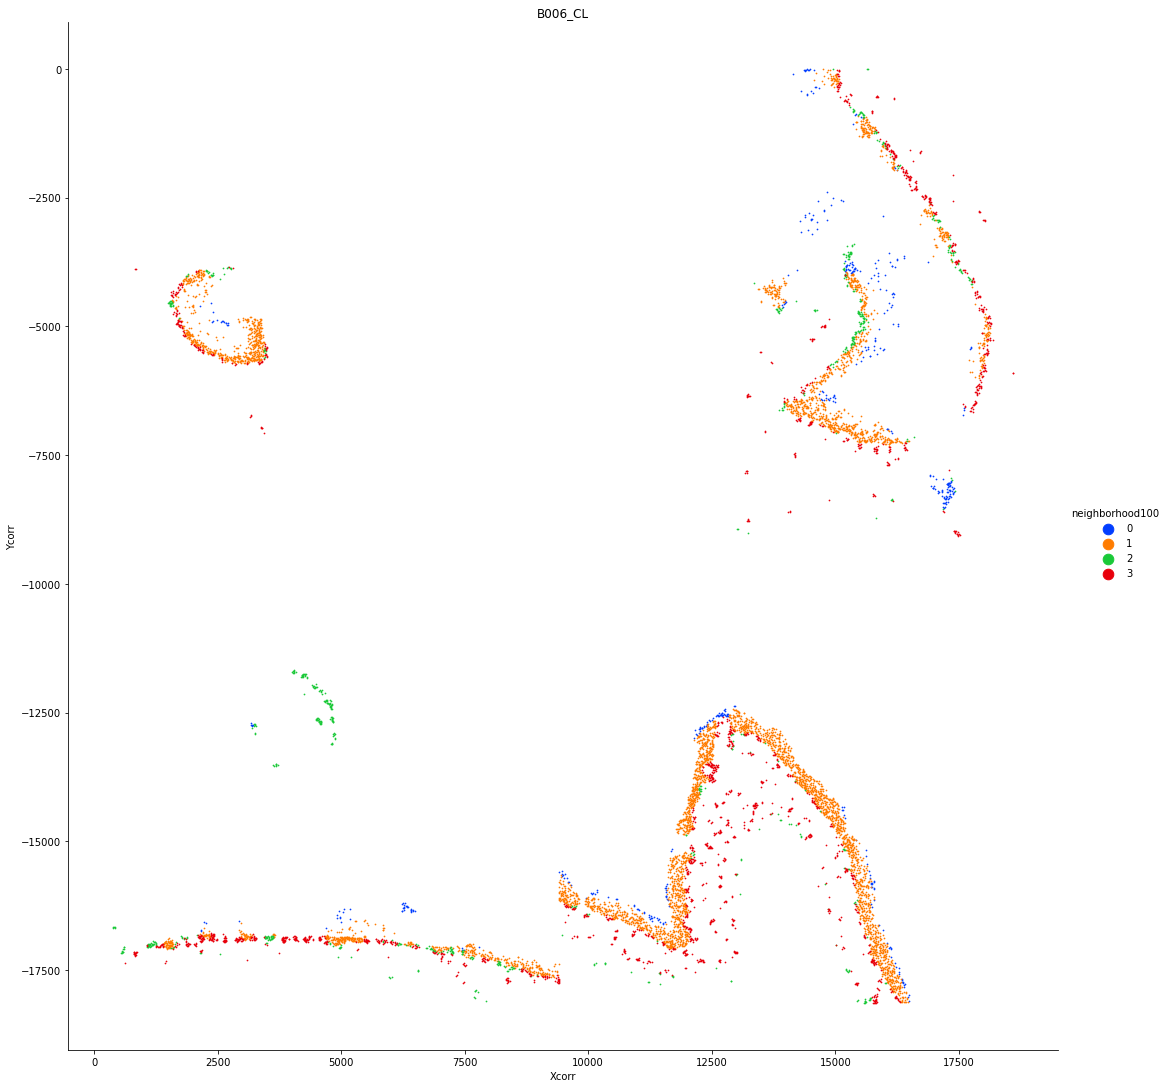

B004_CL


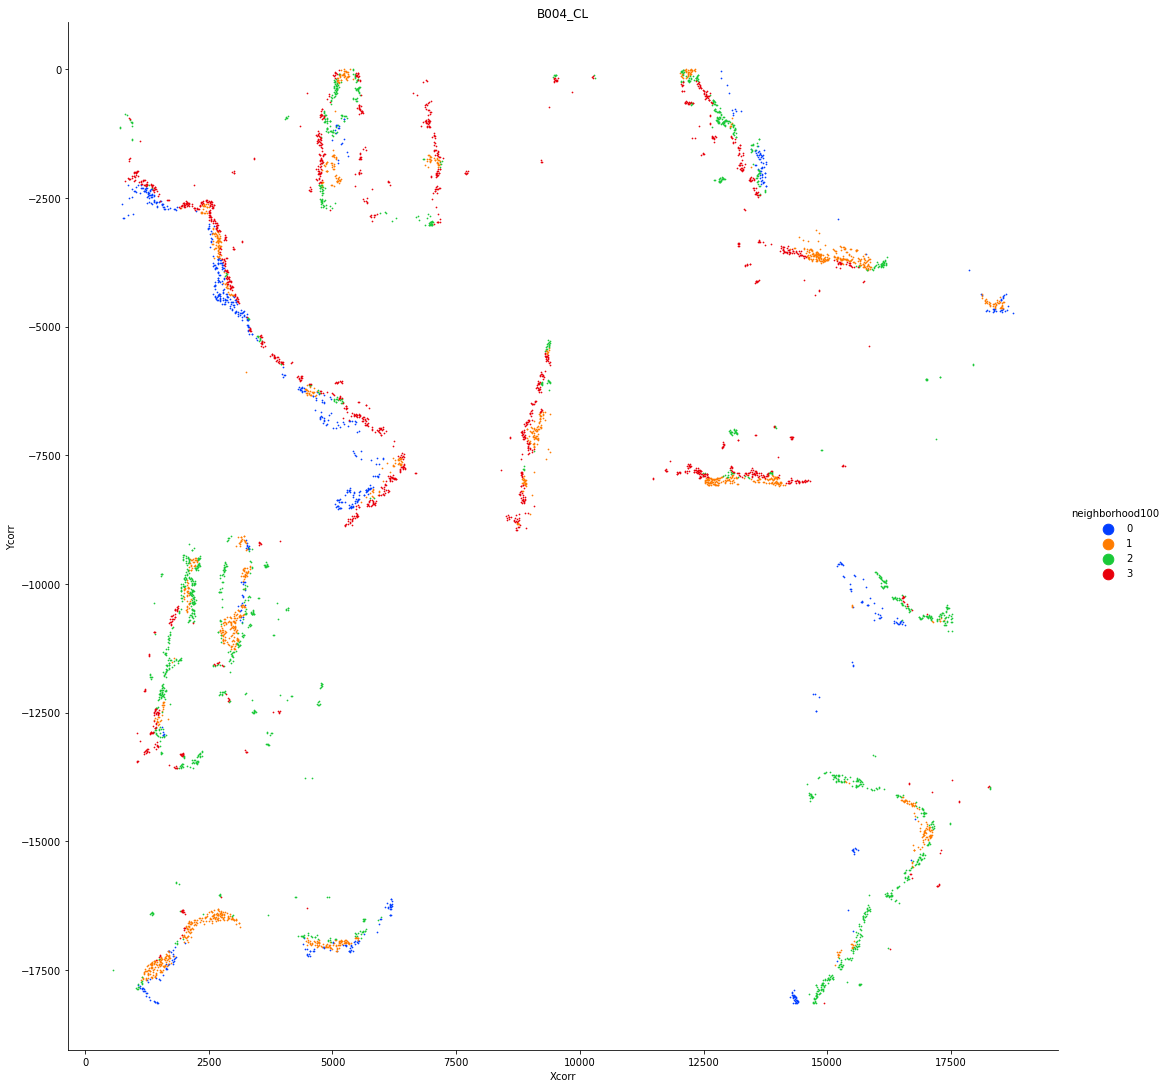

B005_CL


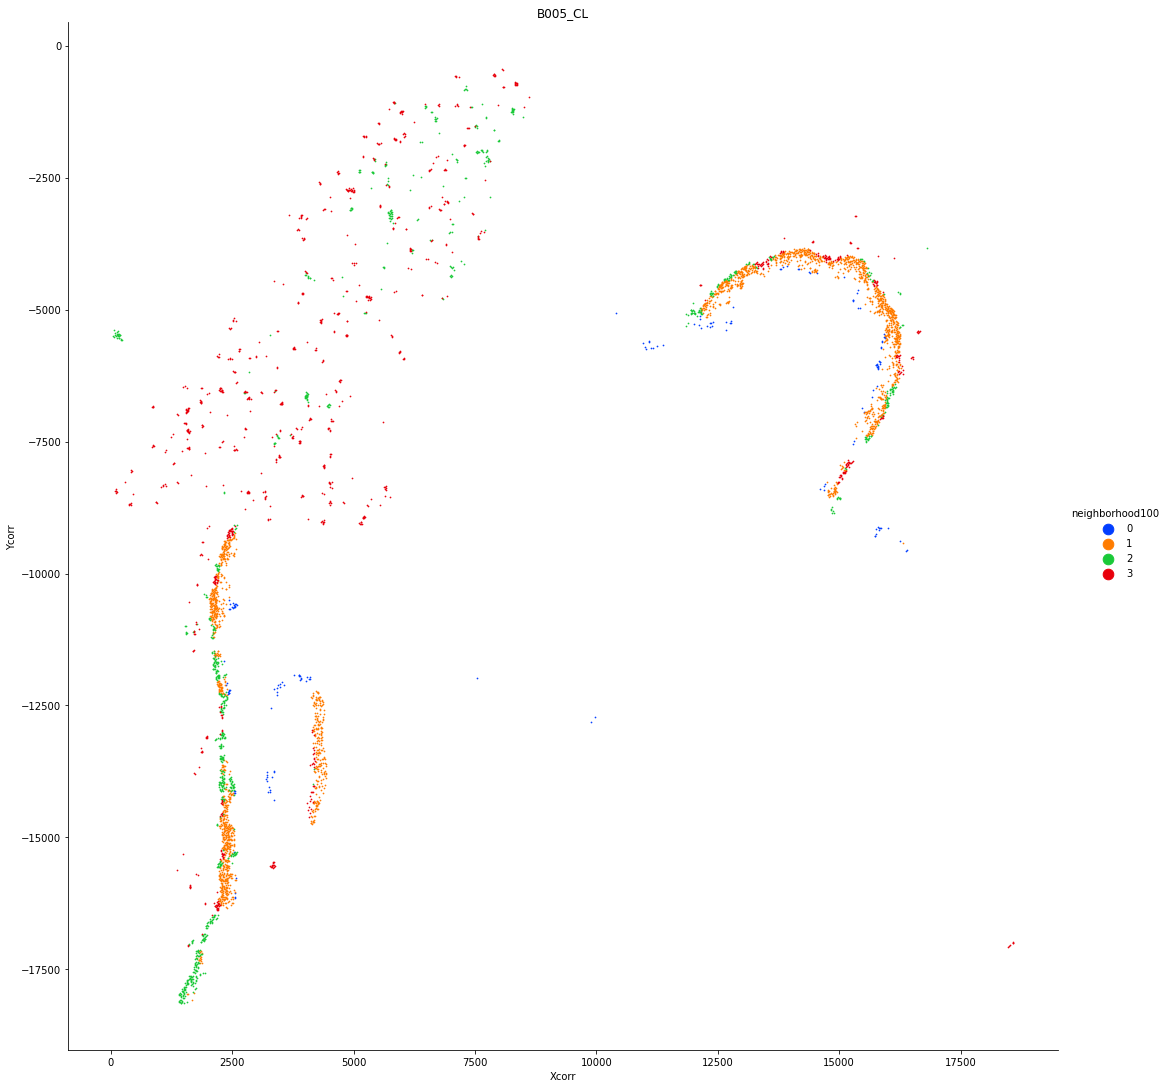

B010A


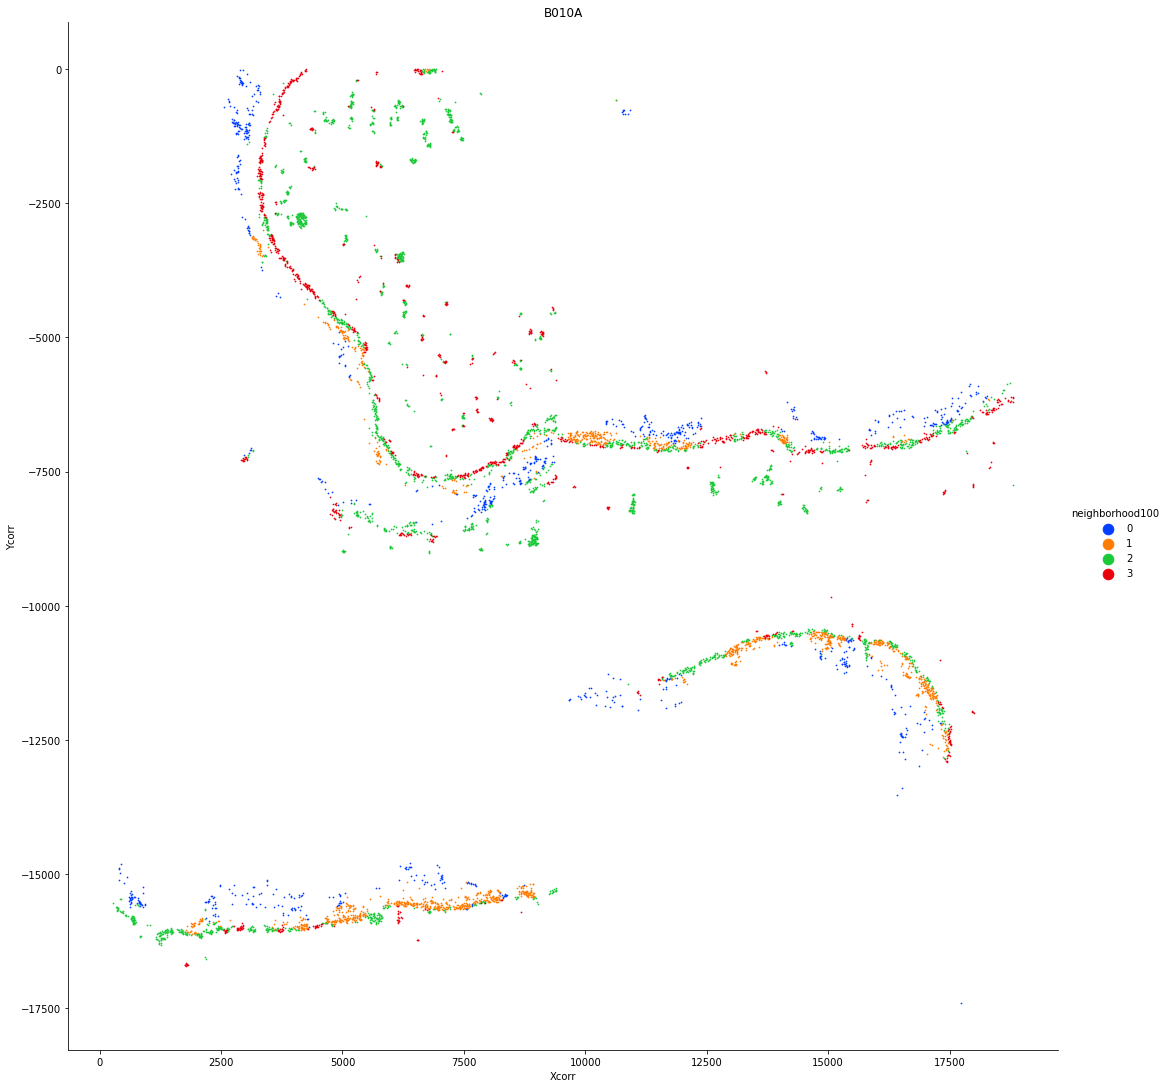

B011A


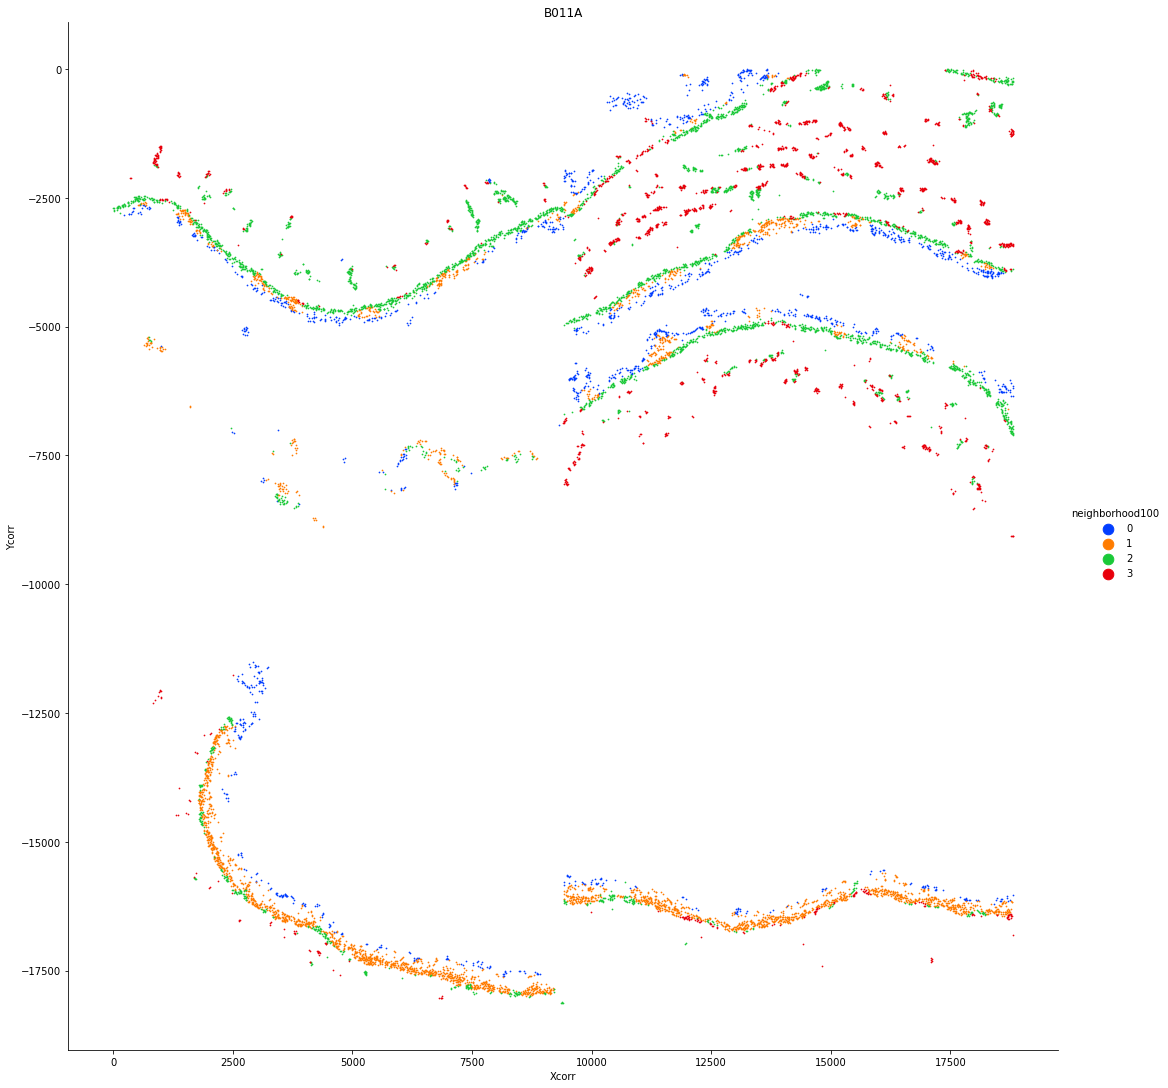

B012A


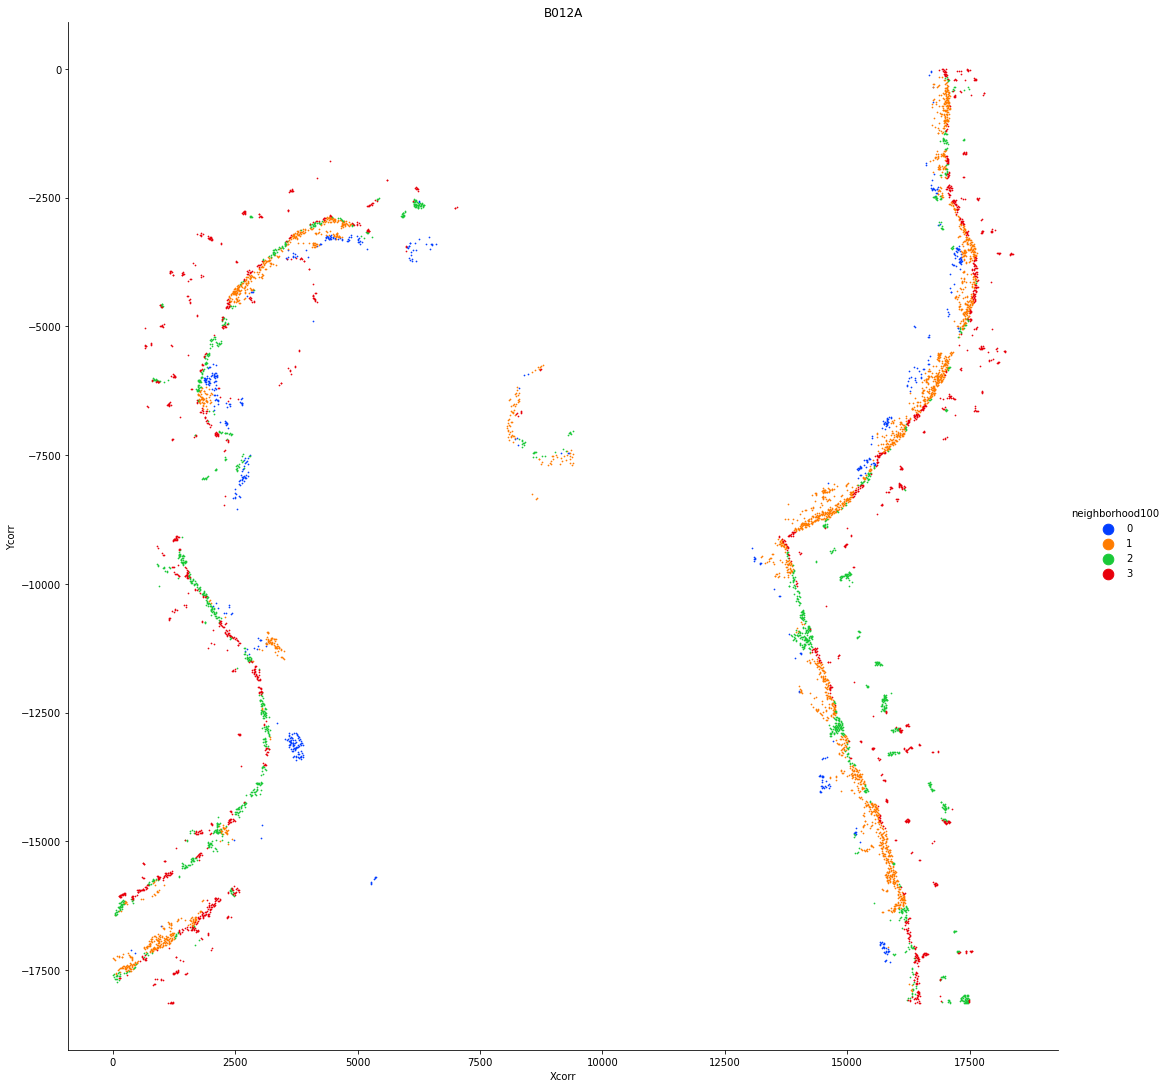

B009A


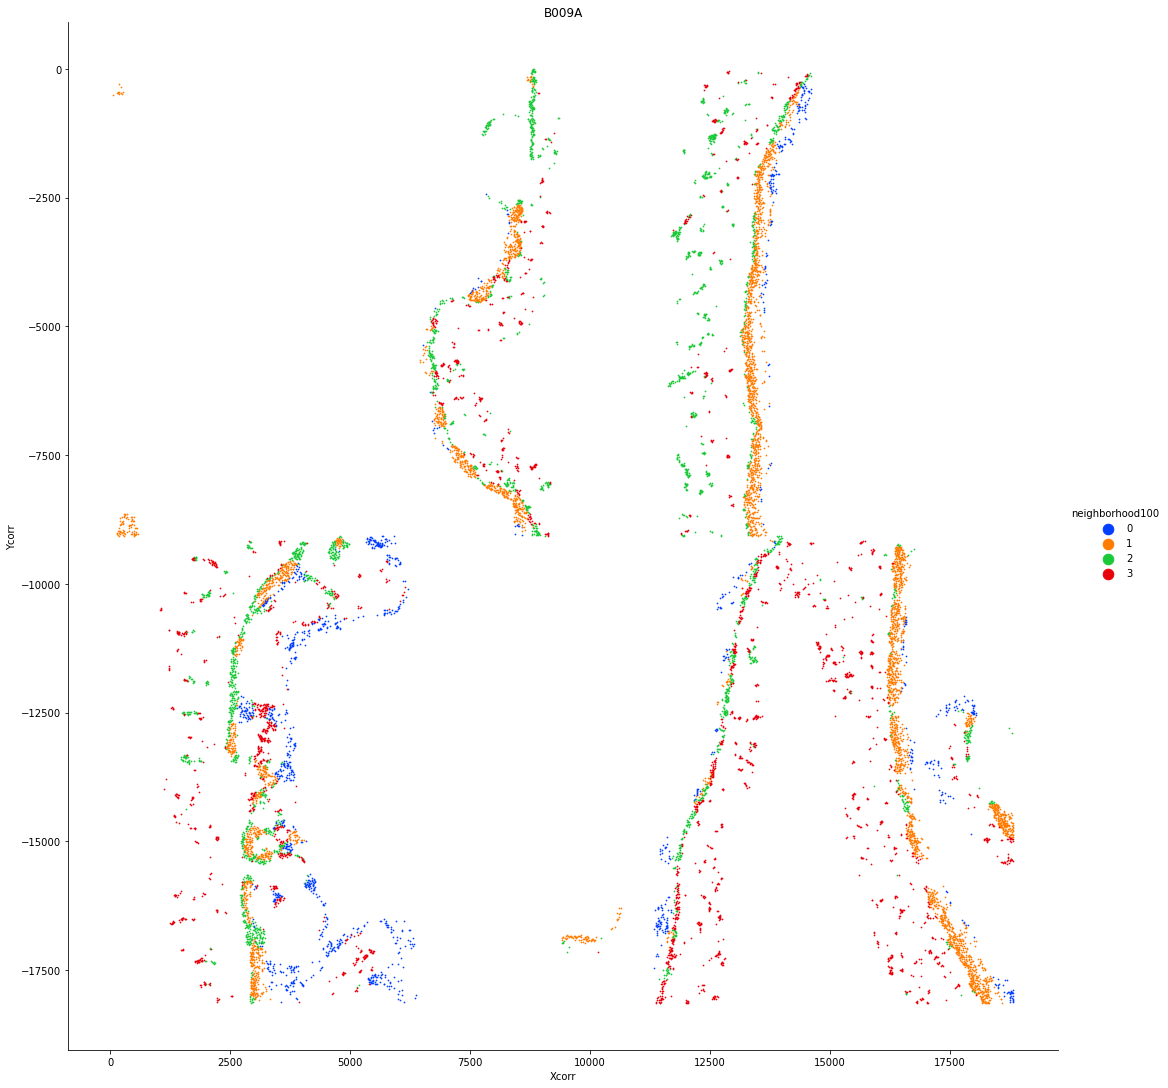

colon


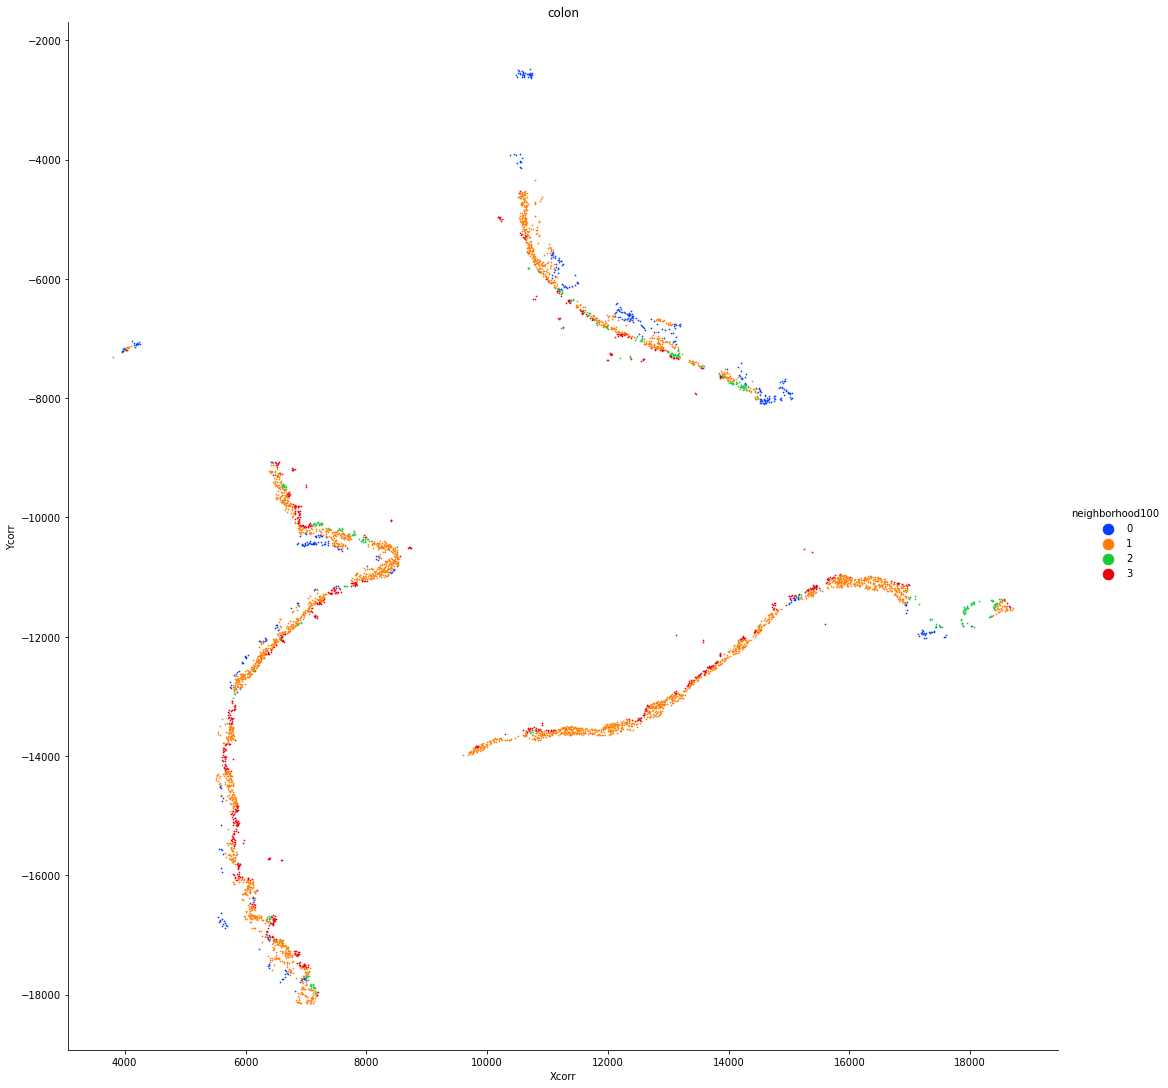

B009Bt


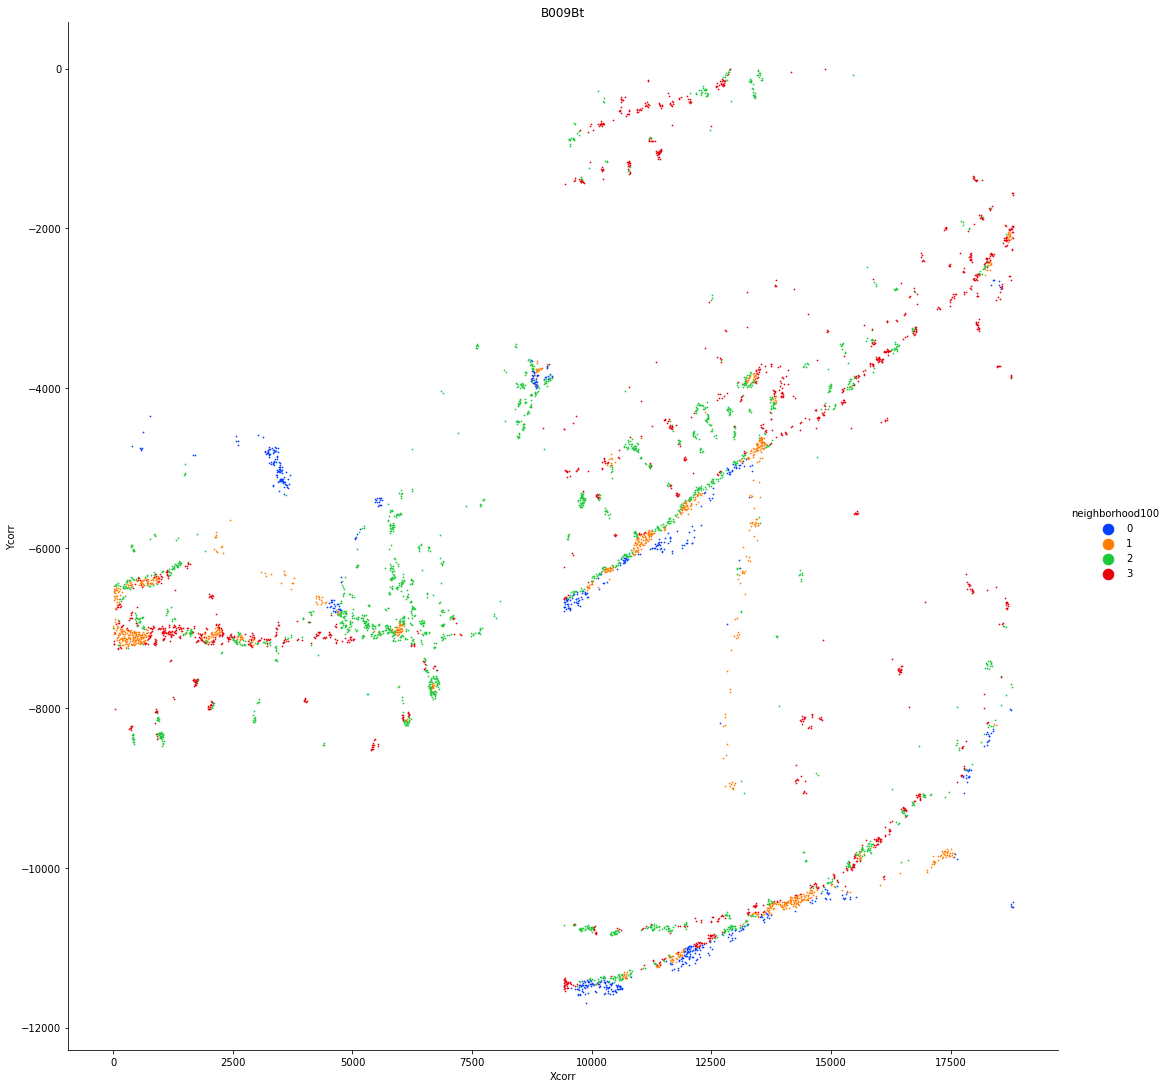

B012B


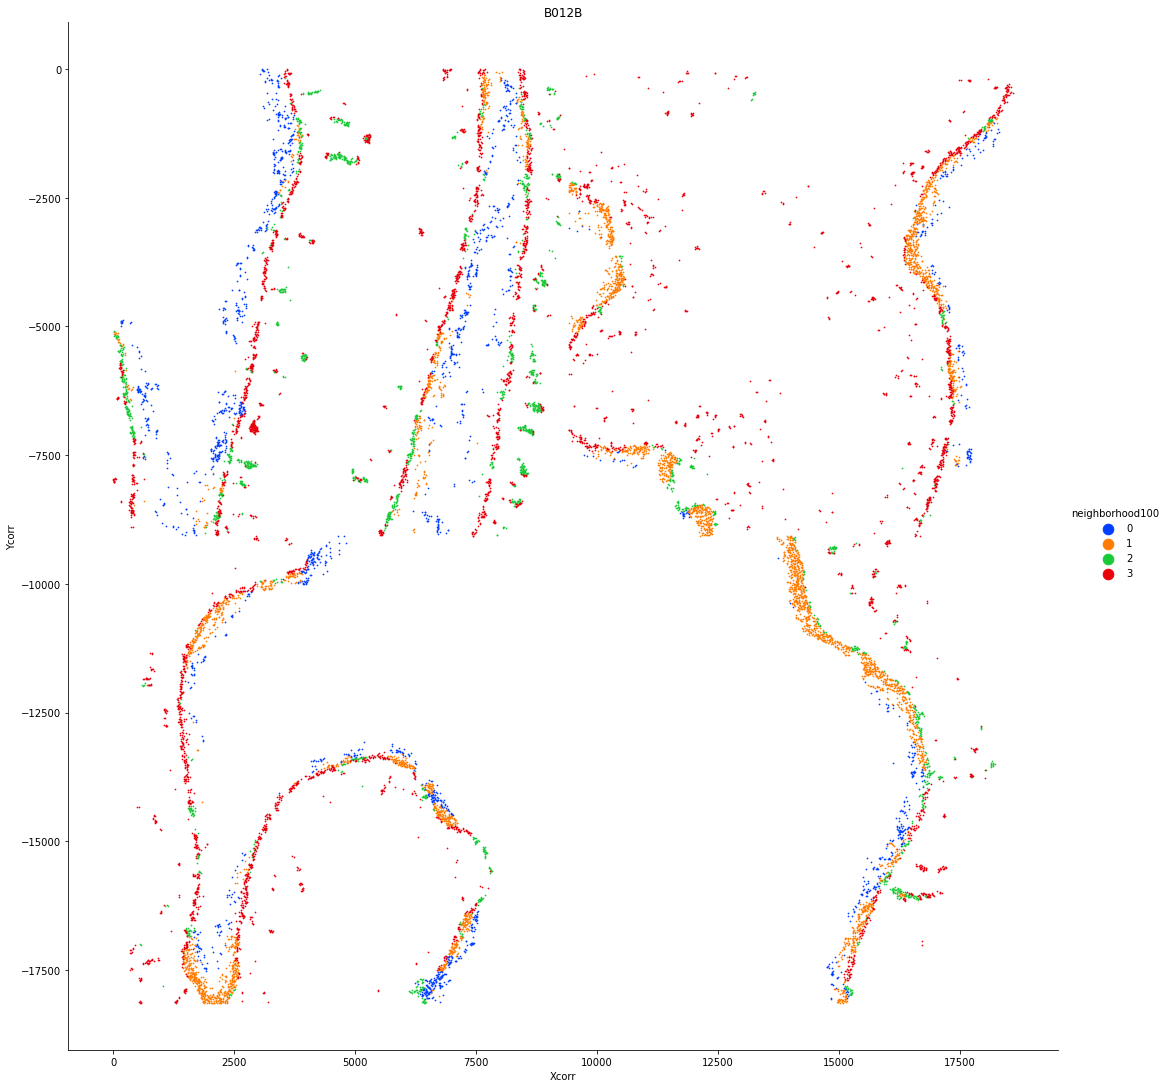

B009B


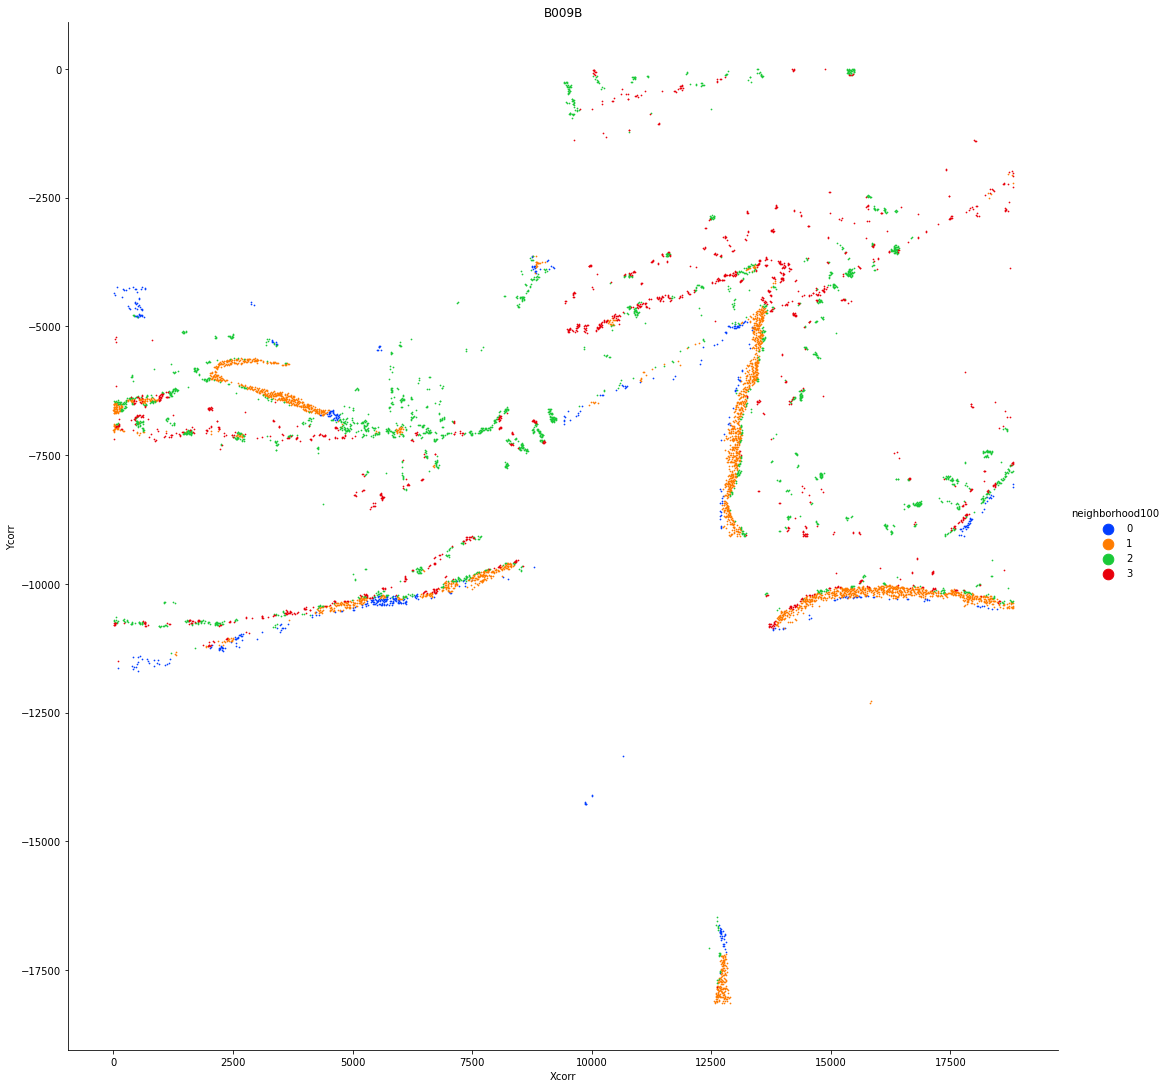

B010B


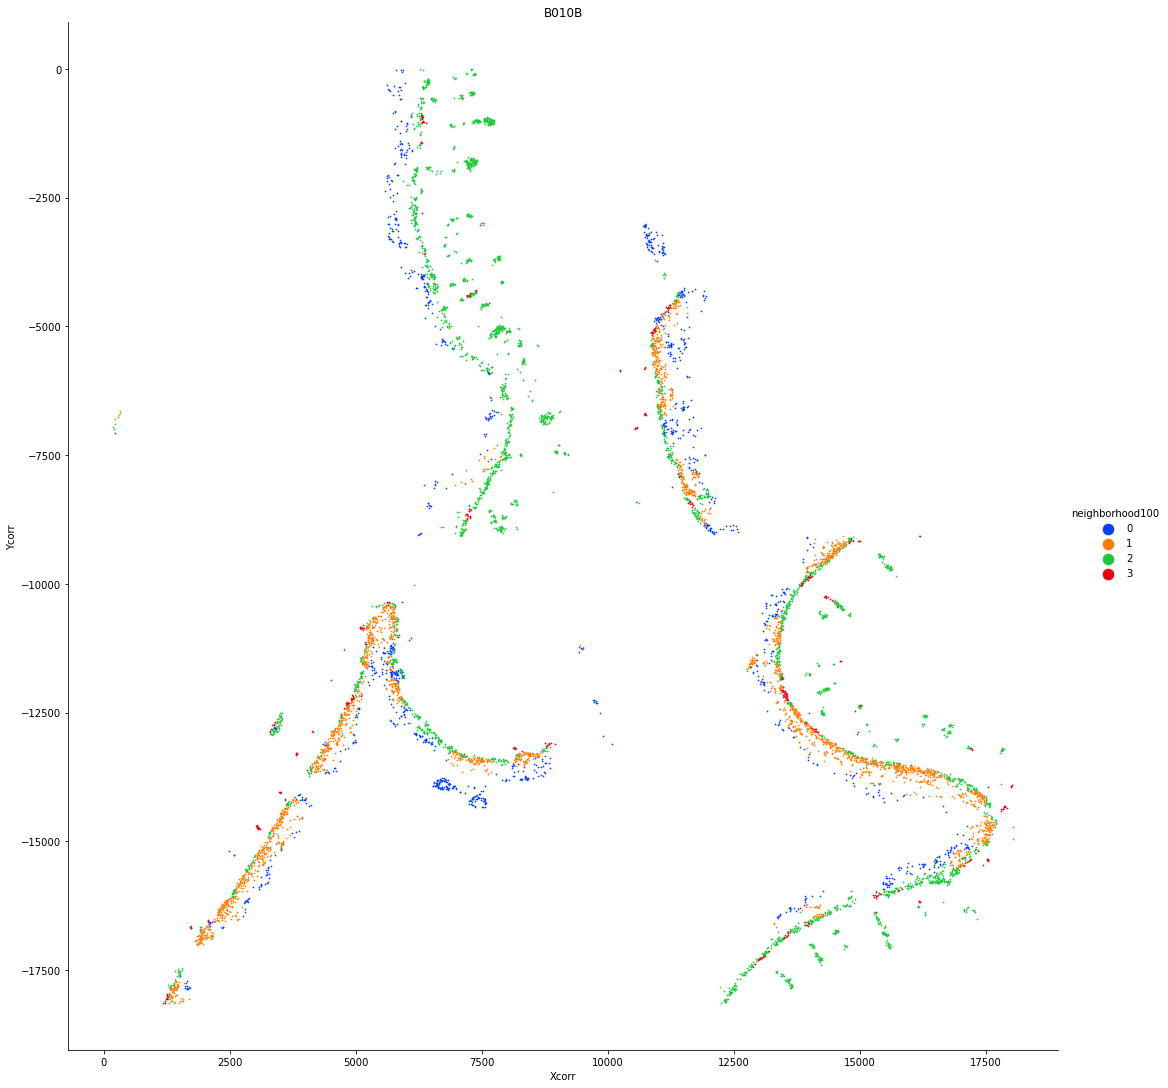

B011B


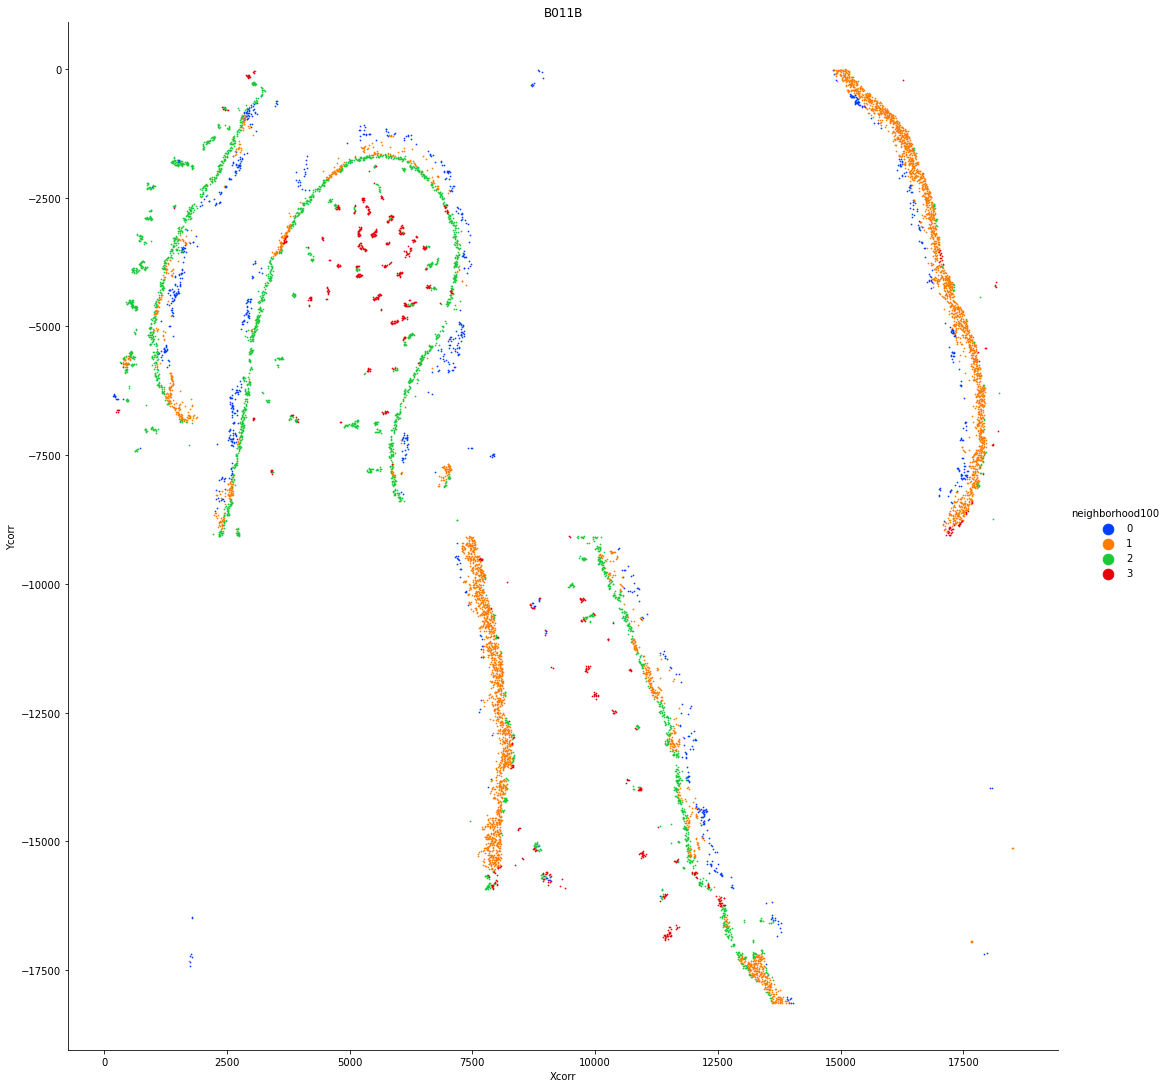

B005_SB


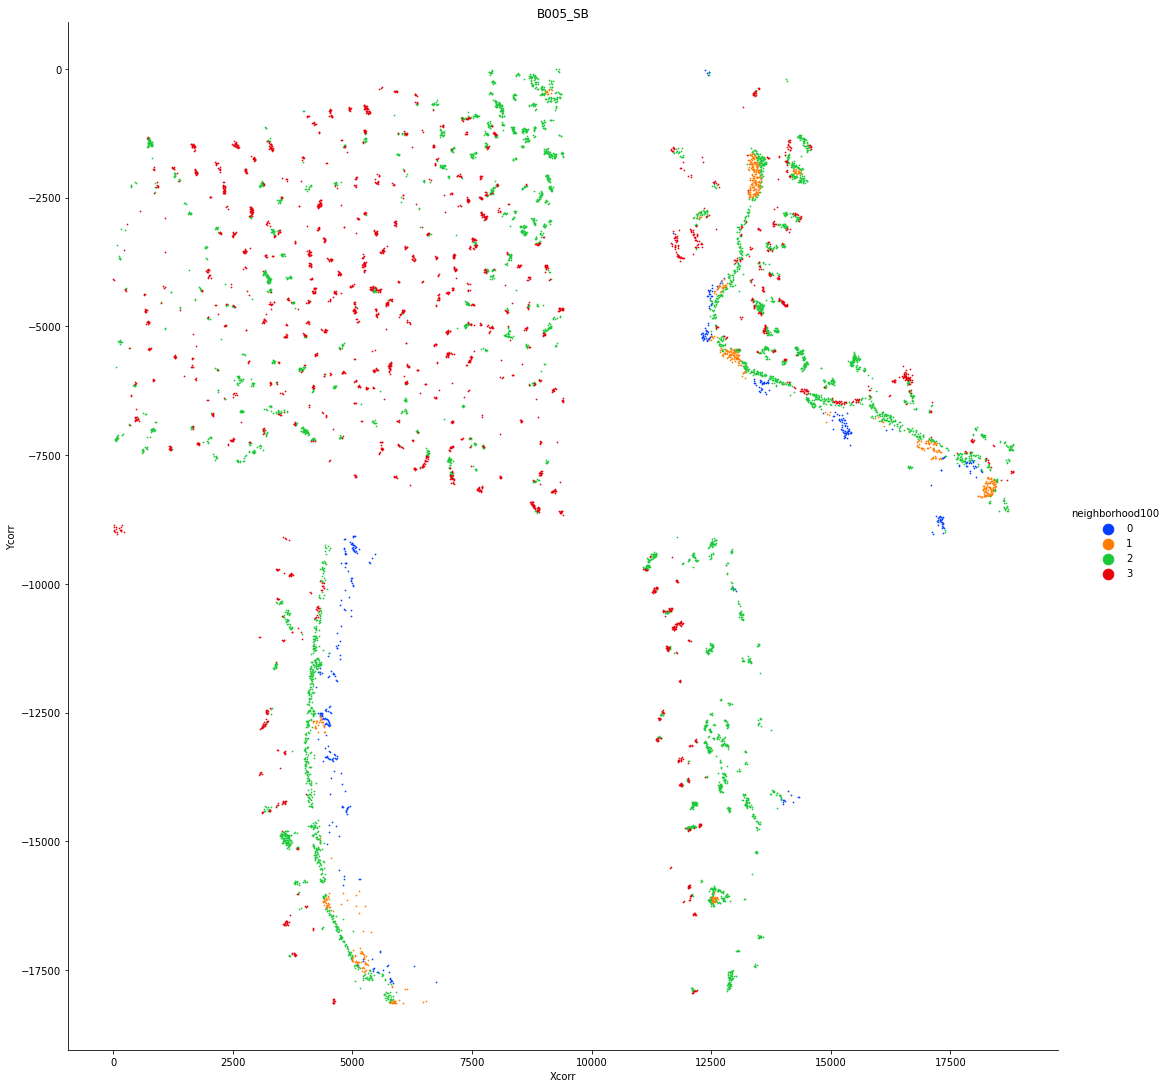

B004_SB


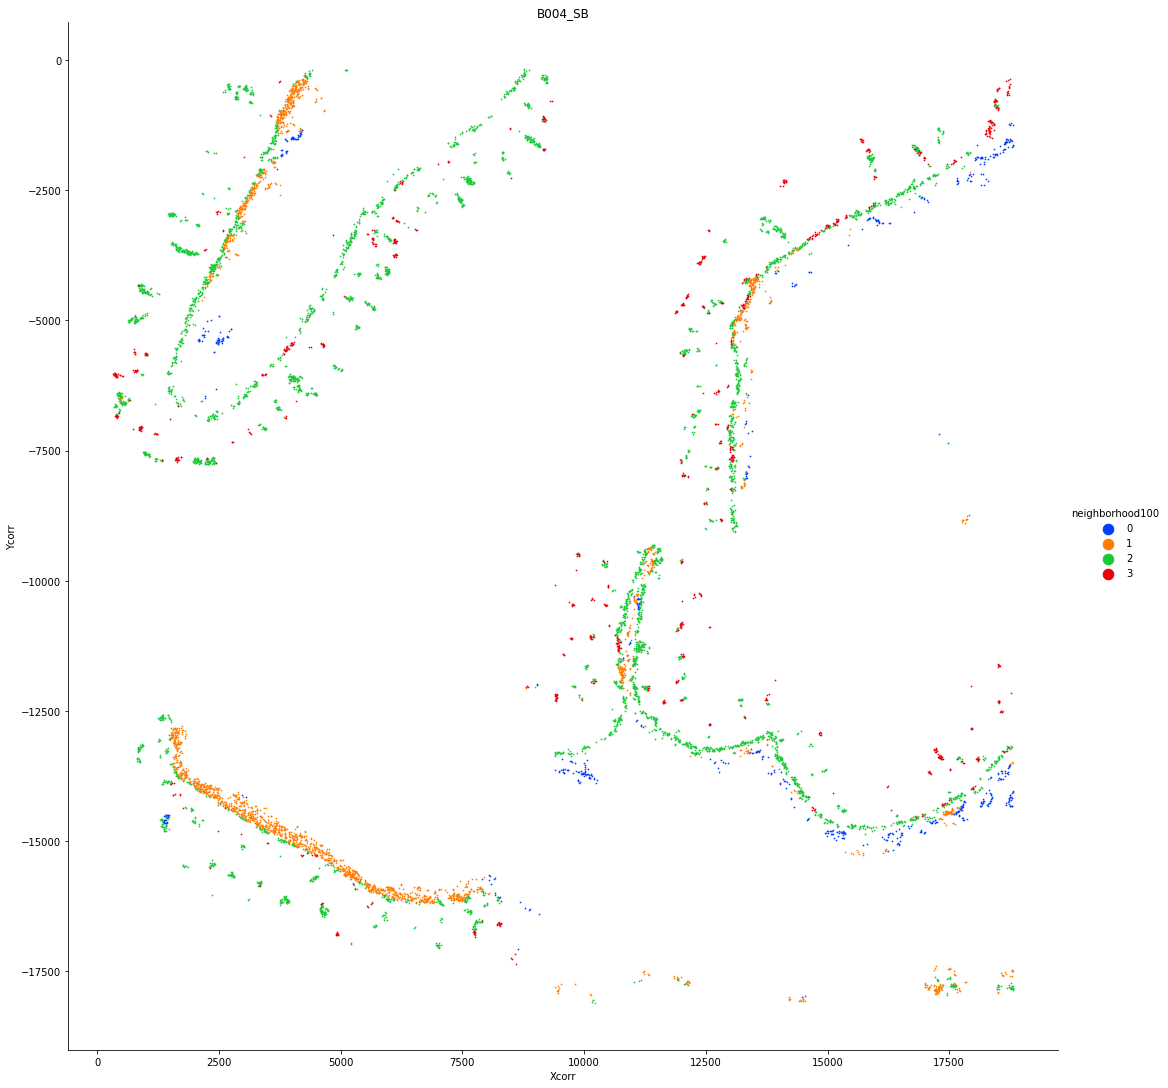

B006_SB


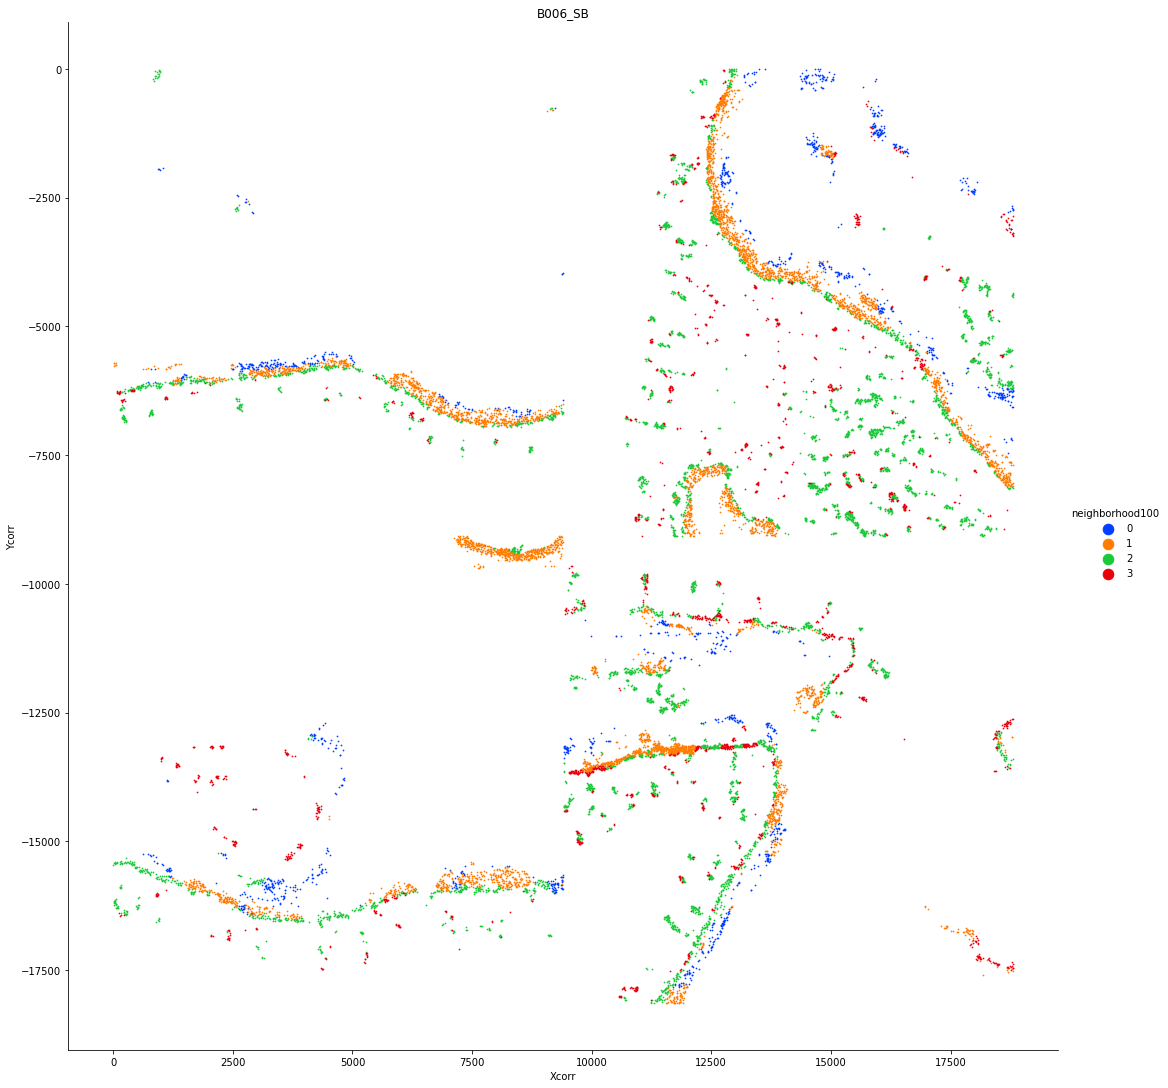

SB


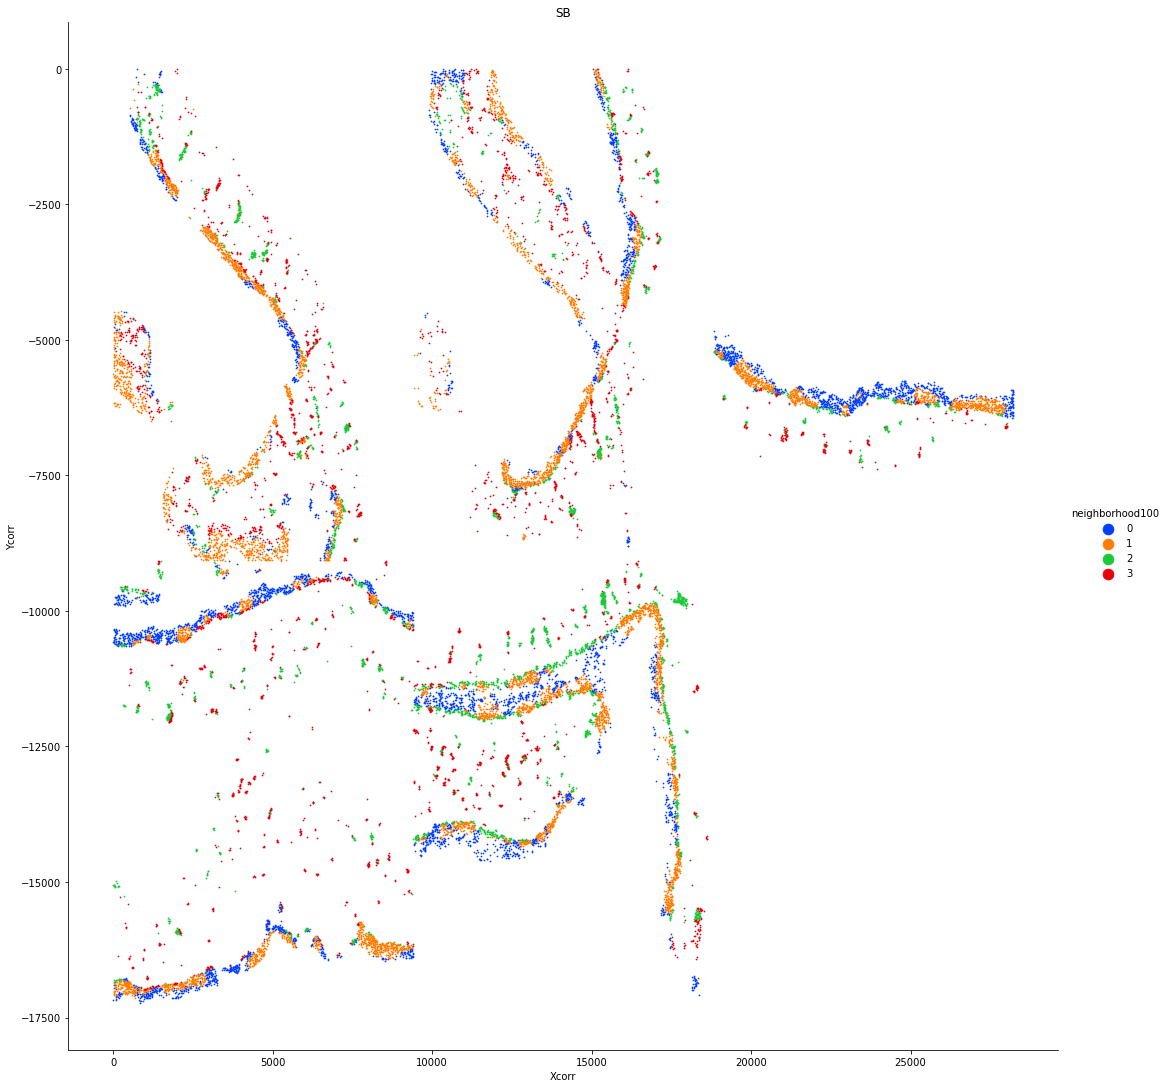

In [22]:
#modify figure size aesthetics for each neighborhood
plt.rcParams["legend.markerscale"] = 15
figs = catplot(MuscleM_cells,X = 'Xcorr',Y='Ycorr',exp = 'array',
               hue = 'neighborhood'+str(k),invert_y=True,size = 2,figsize=15)

In [ ]:
#this plot shows the types of cells (ClusterIDs) in the different niches (0-9)
k_to_plot = k
niche_clusters = (k_centroids[k_to_plot])
tissue_avgs = values.mean(axis = 0)
fc = np.log2(((niche_clusters+tissue_avgs)/(niche_clusters+tissue_avgs).sum(axis = 1, keepdims = True))/tissue_avgs)
fc = pd.DataFrame(fc,columns = sum_cols)
s=sns.clustermap(fc, vmin =-3,vmax = 3,cmap = 'bwr', figsize=(10,10))
#s.savefig(save_path+"celltypes_perniche_"+"_"+str(k)+".png", dpi=600)

In [ ]:
n_conversion_MuscleM = {
    0: 'Muscularis externa',
    1: 'Muscularis externa',
    2: 'Muscularis externa',
    3: 'Submucosa',
    4: 'Muscularis externa',

}
MuscleM_cells['Segment4']=MuscleM_cells[neighborhood_name].map(n_conversion_MuscleM)
MuscleM_cells['Segment4'].unique()

In [ ]:
#modify figure size aesthetics for each neighborhood
plt.rcParams["legend.markerscale"] = 15
figs = catplot(MuscleM_cells,X = 'Xcorr',Y='Ycorr',exp = 'array',
               hue = 'Segment4',invert_y=True,size = 2,figsize=15)

In [ ]:
cond_list = ['Muscle']
Muscle_cells_other = cells[~(cells['Segment3'].isin(cond_list))]
Muscle_cells_other['Segment4'] = Muscle_cells_other['Segment3']
df_all = pd.concat([Muscle_cells_other, Muscle_cells])
df_all.reset_index(inplace=True, drop=True)
df_all.drop(columns=sum_cols, inplace=True)
#modify figure size aesthetics for each neighborhood
plt.rcParams["legend.markerscale"] = 15
figs = catplot(df_all,X = 'Xcorr',Y='Ycorr',exp = 'array',
               hue = 'Segment4',invert_y=True,size = 2,figsize=15)

In [ ]:
df_all.columns

In [ ]:
df_all.drop(columns=[ 'index', 'neighborhood500'],inplace=True)
df_all.columns

In [ ]:
df_all.to_csv(save_path+'05_25_HuBMAP_comm4.csv')